<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/CRNN_Binary_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [12]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI"
classes = ["english","india"]
batch_size = 11

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/English_Indian_Melspec_Img"

aug = True

if aug:
    train_set_folders = [
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [17]:
# can also load in data as numpy arrays directly 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  test_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'test'), transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'validation'), transform=data_transform)

  train_data_components = [torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'train'), transform=data_transform)]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

  return train_data, val_data, test_data

def visualize_image_data(dataset, classes):
  batch = batch_size
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(min(batch,20)):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])
  return(images.shape)

def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return raw_train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 8
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs.float()) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Base Arch

In [9]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

## Data Gen

(11, 3, 128, 192)
128


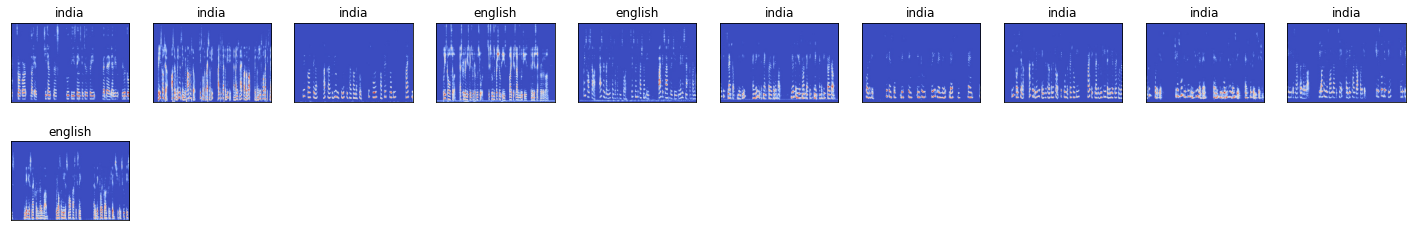

In [18]:
train_data, val_data, test_data= generate_data_image()
(batch_size, dummy, mfcc_bands, length) = visualize_image_data(train_data, classes)
print(mfcc_bands)

In [ ]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

## Train Func

In [23]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    best_val_acc = 0 
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for array, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = array.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.float().cuda()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        if epoch>30 and val_acc[-1]>best_val_acc:
            print("SAVED MODEL")
            model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1) + "_valacc_" + str(val_acc[-1])
            checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, str(epoch+1))
            full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
            try:
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
            except FileNotFoundError:
                os.makedirs(full_checkpoint_path)
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        if val_acc[-1]>best_val_acc:
            best_val_acc = val_acc[-1]
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

# CRNN Binary with Mel Spectogram


In [24]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

### Exp 0: Basic

In [22]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 1
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Indian_MelSpec_Img",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN2(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

Using CUDA


RuntimeError: ignored

### Indian Exp1 - Bigger FC

In [ ]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 40),
                                nn.Linear(40,20),
                            nn.Linear(20, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.6084656084656085 Val Accuracy:  0.6666666666666666 Progress:   2.00  % Time Elapsed:   3.75 s 
Epoch 0 Finished.  Time per Epoch:   3.75 s 
Epoch:  1 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6296296296296297 Progress:   4.00  % Time Elapsed:   7.56 s 
Epoch 1 Finished.  Time per Epoch:   3.78 s 
Epoch:  2 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.5925925925925926 Progress:   6.00  % Time Elapsed:  11.29 s 
Epoch 2 Finished.  Time per Epoch:   3.76 s 
Epoch:  3 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5555555555555556 Progress:   8.00  % Time Elapsed:  15.08 s 
Epoch 3 Finished.  Time per Epoch:   3.77 s 
Epoch:  4 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6296296296296297 Progress:  10.00  % Time Elapsed:  18.85 s 
Epoch 4 Finished.  Time per Epoch:   3.77 s 
Epoch:  5 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  12.00  % Time Elapsed:  22.67 s 
Epoch 5 Finished.  T

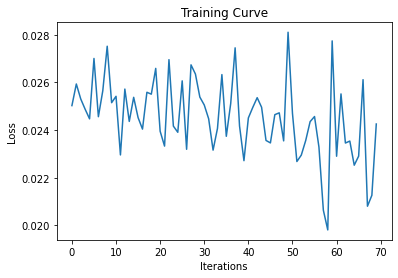

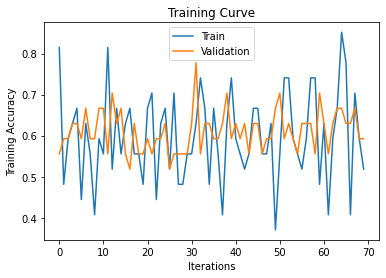

Epoch:  10 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.6666666666666666 Progress:  22.00  % Time Elapsed:  41.88 s 
Epoch 10 Finished.  Time per Epoch:   3.81 s 
Epoch:  11 Train Accuracy:  0.746031746031746 Val Accuracy:  0.5185185185185185 Progress:  24.00  % Time Elapsed:  45.71 s 
Epoch 11 Finished.  Time per Epoch:   3.81 s 
Epoch:  12 Train Accuracy:  0.7354497354497355 Val Accuracy:  0.7037037037037037 Progress:  26.00  % Time Elapsed:  49.47 s 
Epoch 12 Finished.  Time per Epoch:   3.81 s 
Epoch:  13 Train Accuracy:  0.7513227513227513 Val Accuracy:  0.5925925925925926 Progress:  28.00  % Time Elapsed:  53.30 s 
Epoch 13 Finished.  Time per Epoch:   3.81 s 
Epoch:  14 Train Accuracy:  0.7883597883597884 Val Accuracy:  0.7037037037037037 Progress:  30.00  % Time Elapsed:  57.15 s 
Epoch 14 Finished.  Time per Epoch:   3.81 s 
Epoch:  15 Train Accuracy:  0.7407407407407407 Val Accuracy:  0.7037037037037037 Progress:  32.00  % Time Elapsed:  61.00 s 
Epoch 15 Finished.  T

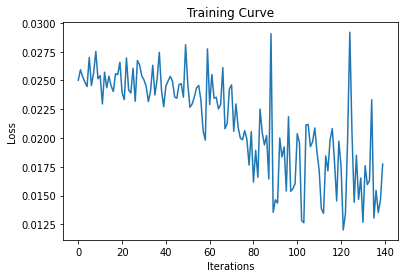

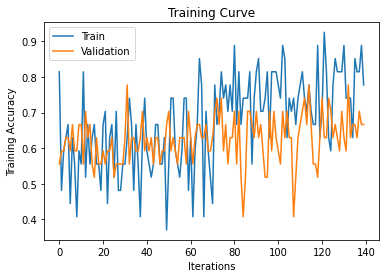

Epoch:  20 Train Accuracy:  0.8201058201058201 Val Accuracy:  0.7407407407407407 Progress:  42.00  % Time Elapsed:  80.63 s 
Epoch 20 Finished.  Time per Epoch:   3.84 s 
Epoch:  21 Train Accuracy:  0.8306878306878307 Val Accuracy:  0.6666666666666666 Progress:  44.00  % Time Elapsed:  84.58 s 
Epoch 21 Finished.  Time per Epoch:   3.84 s 
Epoch:  22 Train Accuracy:  0.7936507936507936 Val Accuracy:  0.6666666666666666 Progress:  46.00  % Time Elapsed:  88.57 s 
Epoch 22 Finished.  Time per Epoch:   3.85 s 
Epoch:  23 Train Accuracy:  0.8518518518518519 Val Accuracy:  0.7037037037037037 Progress:  48.00  % Time Elapsed:  92.52 s 
Epoch 23 Finished.  Time per Epoch:   3.86 s 
Epoch:  24 Train Accuracy:  0.8253968253968254 Val Accuracy:  0.6666666666666666 Progress:  50.00  % Time Elapsed:  96.46 s 
Epoch 24 Finished.  Time per Epoch:   3.86 s 
Epoch:  25 Train Accuracy:  0.8201058201058201 Val Accuracy:  0.5925925925925926 Progress:  52.00  % Time Elapsed:  100.40 s 
Epoch 25 Finished. 

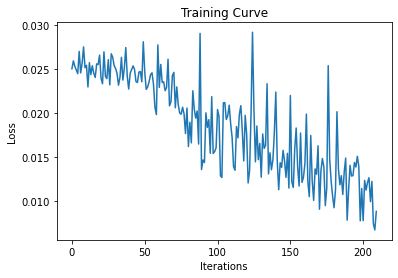

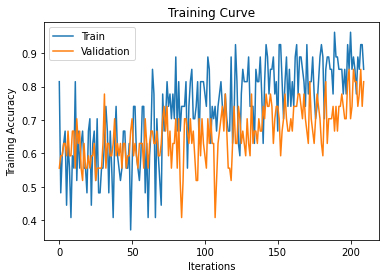

Epoch:  30 Train Accuracy:  0.8941798941798942 Val Accuracy:  0.8148148148148148 Progress:  62.00  % Time Elapsed:  121.34 s 
Epoch 30 Finished.  Time per Epoch:   3.91 s 
Epoch:  31 Train Accuracy:  0.8783068783068783 Val Accuracy:  0.8518518518518519 Progress:  64.00  % Time Elapsed:  125.74 s 
Epoch 31 Finished.  Time per Epoch:   3.93 s 
Epoch:  32 Train Accuracy:  0.8941798941798942 Val Accuracy:  0.8518518518518519 Progress:  66.00  % Time Elapsed:  130.15 s 
Epoch 32 Finished.  Time per Epoch:   3.94 s 
Epoch:  33 Train Accuracy:  0.9153439153439153 Val Accuracy:  0.7777777777777778 Progress:  68.00  % Time Elapsed:  134.58 s 
Epoch 33 Finished.  Time per Epoch:   3.96 s 
Epoch:  34 Train Accuracy:  0.9470899470899471 Val Accuracy:  0.7777777777777778 Progress:  70.00  % Time Elapsed:  138.97 s 
Epoch 34 Finished.  Time per Epoch:   3.97 s 
Epoch:  35 Train Accuracy:  0.9047619047619048 Val Accuracy:  0.8148148148148148 Progress:  72.00  % Time Elapsed:  143.41 s 
Epoch 35 Finis

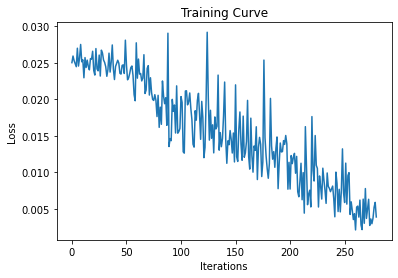

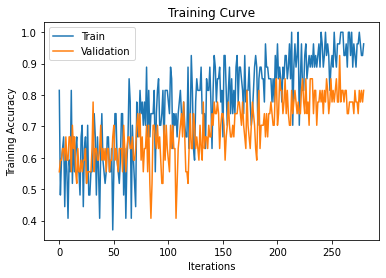

Epoch:  40 Train Accuracy:  0.9788359788359788 Val Accuracy:  0.8148148148148148 Progress:  82.00  % Time Elapsed:  165.26 s 
Epoch 40 Finished.  Time per Epoch:   4.03 s 
Epoch:  41 Train Accuracy:  0.9312169312169312 Val Accuracy:  0.8888888888888888 Progress:  84.00  % Time Elapsed:  168.84 s 
Epoch 41 Finished.  Time per Epoch:   4.02 s 
SAVED MODEL
Epoch:  42 Train Accuracy:  0.9259259259259259 Val Accuracy:  0.7777777777777778 Progress:  86.00  % Time Elapsed:  172.45 s 
Epoch 42 Finished.  Time per Epoch:   4.01 s 
Epoch:  43 Train Accuracy:  0.9735449735449735 Val Accuracy:  0.7777777777777778 Progress:  88.00  % Time Elapsed:  176.06 s 
Epoch 43 Finished.  Time per Epoch:   4.00 s 
Epoch:  44 Train Accuracy:  0.9894179894179894 Val Accuracy:  0.7777777777777778 Progress:  90.00  % Time Elapsed:  179.68 s 
Epoch 44 Finished.  Time per Epoch:   3.99 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  92.00  % Time Elapsed:  183.30 s 
Epoch 45 Finished

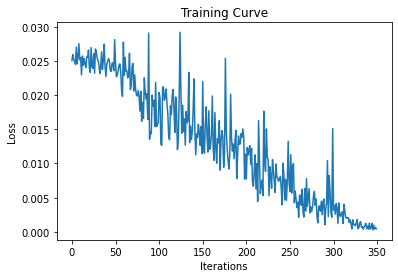

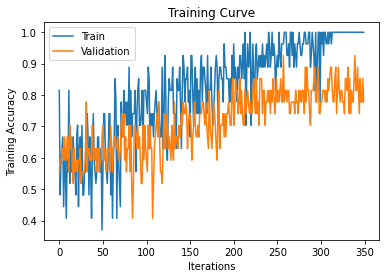

Finished Training
Total time:   198.06 s  Time per Epoch:   3.96 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Indian_MelSpec_Img_bigger_fc",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN2(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

### Indian Exp2 - Lower LR

In [ ]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 40),
                                nn.Linear(40,20),
                            nn.Linear(20, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.3915343915343915 Val Accuracy:  0.3333333333333333 Progress:   2.00  % Time Elapsed:   3.61 s 
Epoch 0 Finished.  Time per Epoch:   3.61 s 
Epoch:  1 Train Accuracy:  0.4126984126984127 Val Accuracy:  0.37037037037037035 Progress:   4.00  % Time Elapsed:   7.16 s 
Epoch 1 Finished.  Time per Epoch:   3.58 s 
Epoch:  2 Train Accuracy:  0.4126984126984127 Val Accuracy:  0.4074074074074074 Progress:   6.00  % Time Elapsed:  10.81 s 
Epoch 2 Finished.  Time per Epoch:   3.60 s 
Epoch:  3 Train Accuracy:  0.48148148148148145 Val Accuracy:  0.5555555555555556 Progress:   8.00  % Time Elapsed:  14.45 s 
Epoch 3 Finished.  Time per Epoch:   3.61 s 
Epoch:  4 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6296296296296297 Progress:  10.00  % Time Elapsed:  18.02 s 
Epoch 4 Finished.  Time per Epoch:   3.60 s 
Epoch:  5 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  12.00  % Time Elapsed:  21.64 s 
Epoch 5 Finished. 

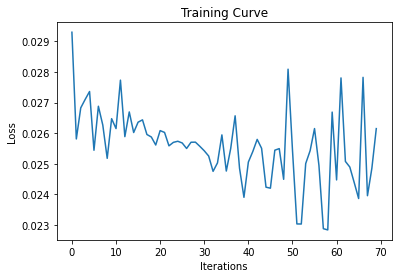

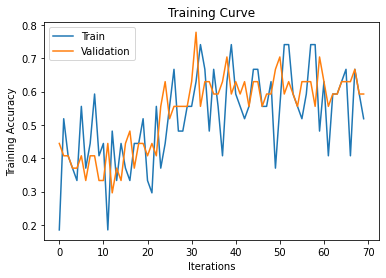

Epoch:  10 Train Accuracy:  0.582010582010582 Val Accuracy:  0.7037037037037037 Progress:  22.00  % Time Elapsed:  40.00 s 
Epoch 10 Finished.  Time per Epoch:   3.64 s 
Epoch:  11 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  24.00  % Time Elapsed:  43.68 s 
Epoch 11 Finished.  Time per Epoch:   3.64 s 
Epoch:  12 Train Accuracy:  0.582010582010582 Val Accuracy:  0.6296296296296297 Progress:  26.00  % Time Elapsed:  47.34 s 
Epoch 12 Finished.  Time per Epoch:   3.64 s 
Epoch:  13 Train Accuracy:  0.5714285714285714 Val Accuracy:  0.5925925925925926 Progress:  28.00  % Time Elapsed:  51.06 s 
Epoch 13 Finished.  Time per Epoch:   3.65 s 
Epoch:  14 Train Accuracy:  0.582010582010582 Val Accuracy:  0.5555555555555556 Progress:  30.00  % Time Elapsed:  54.72 s 
Epoch 14 Finished.  Time per Epoch:   3.65 s 
Epoch:  15 Train Accuracy:  0.582010582010582 Val Accuracy:  0.5555555555555556 Progress:  32.00  % Time Elapsed:  58.41 s 
Epoch 15 Finished.  Time

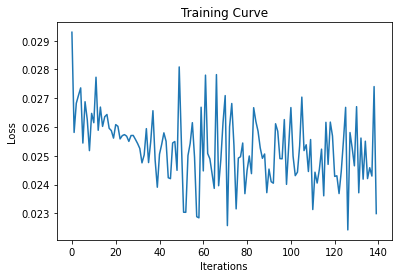

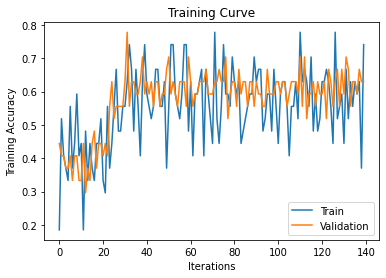

Epoch:  20 Train Accuracy:  0.582010582010582 Val Accuracy:  0.5925925925925926 Progress:  42.00  % Time Elapsed:  77.73 s 
Epoch 20 Finished.  Time per Epoch:   3.70 s 
Epoch:  21 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6666666666666666 Progress:  44.00  % Time Elapsed:  81.59 s 
Epoch 21 Finished.  Time per Epoch:   3.71 s 
Epoch:  22 Train Accuracy:  0.582010582010582 Val Accuracy:  0.6296296296296297 Progress:  46.00  % Time Elapsed:  85.41 s 
Epoch 22 Finished.  Time per Epoch:   3.71 s 
Epoch:  23 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.6296296296296297 Progress:  48.00  % Time Elapsed:  89.24 s 
Epoch 23 Finished.  Time per Epoch:   3.72 s 
Epoch:  24 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.5925925925925926 Progress:  50.00  % Time Elapsed:  93.08 s 
Epoch 24 Finished.  Time per Epoch:   3.72 s 
Epoch:  25 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.5925925925925926 Progress:  52.00  % Time Elapsed:  96.91 s 
Epoch 25 Finished.  Ti

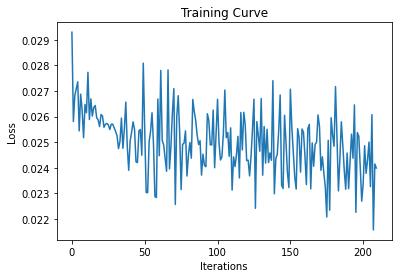

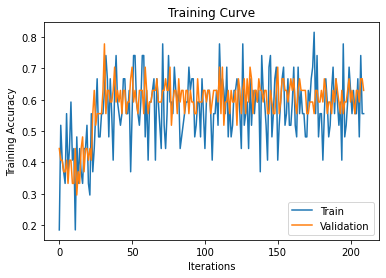

Epoch:  30 Train Accuracy:  0.5978835978835979 Val Accuracy:  0.6296296296296297 Progress:  62.00  % Time Elapsed:  116.39 s 
Epoch 30 Finished.  Time per Epoch:   3.75 s 
Epoch:  31 Train Accuracy:  0.5714285714285714 Val Accuracy:  0.6666666666666666 Progress:  64.00  % Time Elapsed:  120.31 s 
Epoch 31 Finished.  Time per Epoch:   3.76 s 
Epoch:  32 Train Accuracy:  0.5978835978835979 Val Accuracy:  0.7037037037037037 Progress:  66.00  % Time Elapsed:  124.23 s 
Epoch 32 Finished.  Time per Epoch:   3.76 s 
Epoch:  33 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  68.00  % Time Elapsed:  128.16 s 
Epoch 33 Finished.  Time per Epoch:   3.77 s 
Epoch:  34 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  70.00  % Time Elapsed:  132.10 s 
Epoch 34 Finished.  Time per Epoch:   3.77 s 
Epoch:  35 Train Accuracy:  0.6402116402116402 Val Accuracy:  0.6666666666666666 Progress:  72.00  % Time Elapsed:  136.03 s 
Epoch 35 Finis

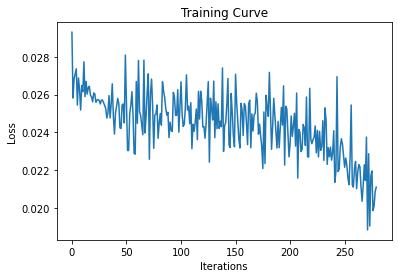

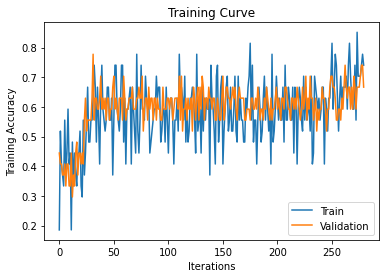

Epoch:  40 Train Accuracy:  0.7354497354497355 Val Accuracy:  0.6666666666666666 Progress:  82.00  % Time Elapsed:  156.10 s 
Epoch 40 Finished.  Time per Epoch:   3.81 s 
Epoch:  41 Train Accuracy:  0.708994708994709 Val Accuracy:  0.7407407407407407 Progress:  84.00  % Time Elapsed:  160.16 s 
Epoch 41 Finished.  Time per Epoch:   3.81 s 
SAVED MODEL
Epoch:  42 Train Accuracy:  0.7513227513227513 Val Accuracy:  0.5925925925925926 Progress:  86.00  % Time Elapsed:  164.21 s 
Epoch 42 Finished.  Time per Epoch:   3.82 s 
Epoch:  43 Train Accuracy:  0.708994708994709 Val Accuracy:  0.5925925925925926 Progress:  88.00  % Time Elapsed:  168.23 s 
Epoch 43 Finished.  Time per Epoch:   3.82 s 
Epoch:  44 Train Accuracy:  0.7619047619047619 Val Accuracy:  0.7037037037037037 Progress:  90.00  % Time Elapsed:  172.31 s 
Epoch 44 Finished.  Time per Epoch:   3.83 s 
Epoch:  45 Train Accuracy:  0.783068783068783 Val Accuracy:  0.6666666666666666 Progress:  92.00  % Time Elapsed:  176.47 s 
Epoch

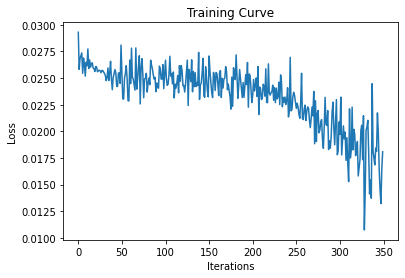

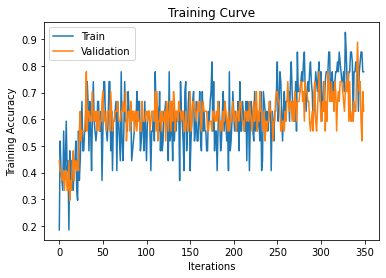

Finished Training
Total time:   193.12 s  Time per Epoch:   3.86 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0001
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Indian_MelSpec_Img_exp2",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN2(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

### Indian Exp3 - Beeger FC layers again

In [ ]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 40),
                                nn.Linear(40,20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.5026455026455027 Val Accuracy:  0.6666666666666666 Progress:   2.00  % Time Elapsed:   4.19 s 
Epoch 0 Finished.  Time per Epoch:   4.19 s 
Epoch:  1 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6296296296296297 Progress:   4.00  % Time Elapsed:   8.40 s 
Epoch 1 Finished.  Time per Epoch:   4.20 s 
Epoch:  2 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.5925925925925926 Progress:   6.00  % Time Elapsed:  12.63 s 
Epoch 2 Finished.  Time per Epoch:   4.21 s 
Epoch:  3 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5555555555555556 Progress:   8.00  % Time Elapsed:  16.81 s 
Epoch 3 Finished.  Time per Epoch:   4.20 s 
Epoch:  4 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6296296296296297 Progress:  10.00  % Time Elapsed:  21.02 s 
Epoch 4 Finished.  Time per Epoch:   4.20 s 
Epoch:  5 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  12.00  % Time Elapsed:  25.24 s 
Epoch 5 Finished.  T

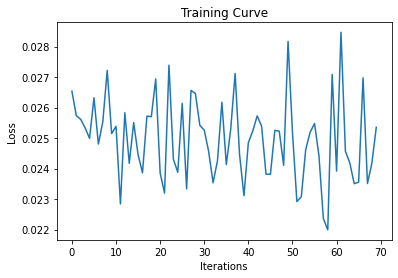

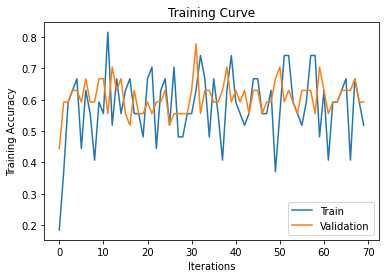

Epoch:  10 Train Accuracy:  0.582010582010582 Val Accuracy:  0.7037037037037037 Progress:  22.00  % Time Elapsed:  45.77 s 
Epoch 10 Finished.  Time per Epoch:   4.16 s 
Epoch:  11 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  24.00  % Time Elapsed:  48.99 s 
Epoch 11 Finished.  Time per Epoch:   4.08 s 
Epoch:  12 Train Accuracy:  0.6613756613756614 Val Accuracy:  0.6296296296296297 Progress:  26.00  % Time Elapsed:  52.17 s 
Epoch 12 Finished.  Time per Epoch:   4.01 s 
Epoch:  13 Train Accuracy:  0.6349206349206349 Val Accuracy:  0.5555555555555556 Progress:  28.00  % Time Elapsed:  55.38 s 
Epoch 13 Finished.  Time per Epoch:   3.96 s 
Epoch:  14 Train Accuracy:  0.7142857142857143 Val Accuracy:  0.7037037037037037 Progress:  30.00  % Time Elapsed:  58.54 s 
Epoch 14 Finished.  Time per Epoch:   3.90 s 
Epoch:  15 Train Accuracy:  0.6455026455026455 Val Accuracy:  0.5925925925925926 Progress:  32.00  % Time Elapsed:  61.72 s 
Epoch 15 Finished.  T

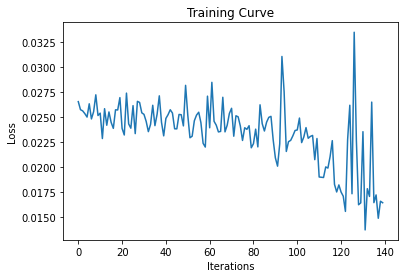

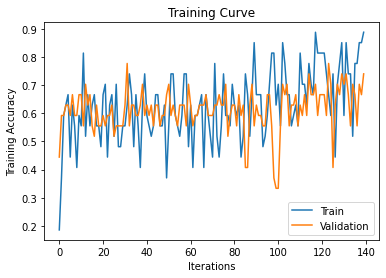

Epoch:  20 Train Accuracy:  0.746031746031746 Val Accuracy:  0.6666666666666666 Progress:  42.00  % Time Elapsed:  78.08 s 
Epoch 20 Finished.  Time per Epoch:   3.72 s 
Epoch:  21 Train Accuracy:  0.8042328042328042 Val Accuracy:  0.7037037037037037 Progress:  44.00  % Time Elapsed:  81.46 s 
Epoch 21 Finished.  Time per Epoch:   3.70 s 
Epoch:  22 Train Accuracy:  0.7883597883597884 Val Accuracy:  0.6296296296296297 Progress:  46.00  % Time Elapsed:  84.77 s 
Epoch 22 Finished.  Time per Epoch:   3.69 s 
Epoch:  23 Train Accuracy:  0.8201058201058201 Val Accuracy:  0.5925925925925926 Progress:  48.00  % Time Elapsed:  88.04 s 
Epoch 23 Finished.  Time per Epoch:   3.67 s 
Epoch:  24 Train Accuracy:  0.8201058201058201 Val Accuracy:  0.6666666666666666 Progress:  50.00  % Time Elapsed:  91.33 s 
Epoch 24 Finished.  Time per Epoch:   3.65 s 
Epoch:  25 Train Accuracy:  0.8412698412698413 Val Accuracy:  0.7037037037037037 Progress:  52.00  % Time Elapsed:  94.62 s 
Epoch 25 Finished.  T

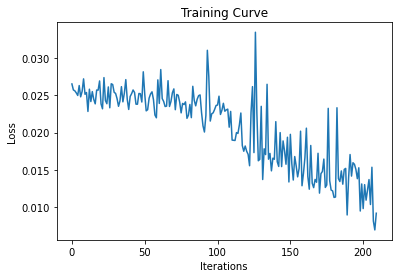

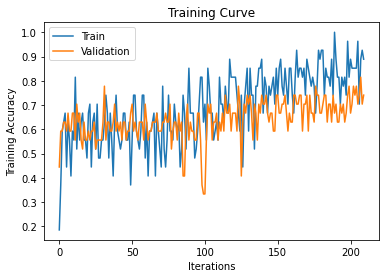

Epoch:  30 Train Accuracy:  0.8783068783068783 Val Accuracy:  0.7777777777777778 Progress:  62.00  % Time Elapsed:  111.44 s 
Epoch 30 Finished.  Time per Epoch:   3.59 s 
Epoch:  31 Train Accuracy:  0.8677248677248677 Val Accuracy:  0.8148148148148148 Progress:  64.00  % Time Elapsed:  114.88 s 
Epoch 31 Finished.  Time per Epoch:   3.59 s 
SAVED MODEL
Epoch:  32 Train Accuracy:  0.91005291005291 Val Accuracy:  0.7777777777777778 Progress:  66.00  % Time Elapsed:  118.32 s 
Epoch 32 Finished.  Time per Epoch:   3.59 s 
Epoch:  33 Train Accuracy:  0.9312169312169312 Val Accuracy:  0.7407407407407407 Progress:  68.00  % Time Elapsed:  121.77 s 
Epoch 33 Finished.  Time per Epoch:   3.58 s 
Epoch:  34 Train Accuracy:  0.9417989417989417 Val Accuracy:  0.7407407407407407 Progress:  70.00  % Time Elapsed:  125.24 s 
Epoch 34 Finished.  Time per Epoch:   3.58 s 
Epoch:  35 Train Accuracy:  0.9470899470899471 Val Accuracy:  0.8148148148148148 Progress:  72.00  % Time Elapsed:  128.65 s 
Epoc

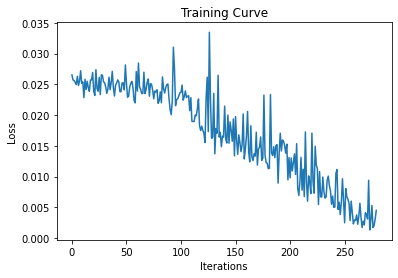

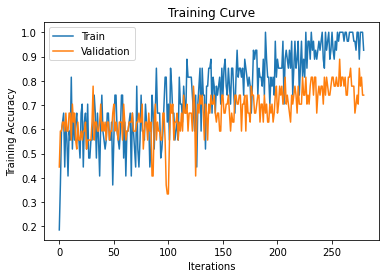

Epoch:  40 Train Accuracy:  0.9841269841269841 Val Accuracy:  0.8148148148148148 Progress:  82.00  % Time Elapsed:  146.53 s 
Epoch 40 Finished.  Time per Epoch:   3.57 s 
Epoch:  41 Train Accuracy:  0.9947089947089947 Val Accuracy:  0.8888888888888888 Progress:  84.00  % Time Elapsed:  150.22 s 
Epoch 41 Finished.  Time per Epoch:   3.58 s 
SAVED MODEL
Epoch:  42 Train Accuracy:  0.9841269841269841 Val Accuracy:  0.6296296296296297 Progress:  86.00  % Time Elapsed:  153.79 s 
Epoch 42 Finished.  Time per Epoch:   3.58 s 
Epoch:  43 Train Accuracy:  0.9894179894179894 Val Accuracy:  0.7777777777777778 Progress:  88.00  % Time Elapsed:  157.35 s 
Epoch 43 Finished.  Time per Epoch:   3.58 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  90.00  % Time Elapsed:  160.89 s 
Epoch 44 Finished.  Time per Epoch:   3.58 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  92.00  % Time Elapsed:  164.40 s 
Epoch 45 Finished.  Time per Epo

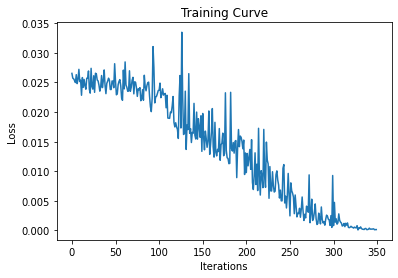

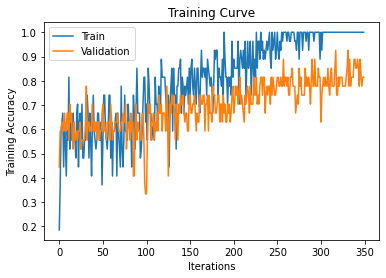

Finished Training
Total time:   178.98 s  Time per Epoch:   3.58 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Indian_MelSpec_Img_exp3",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN2(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

### Indian Exp4 - More Conv Layers

In [ ]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 40),
                                nn.Linear(40,20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
tor

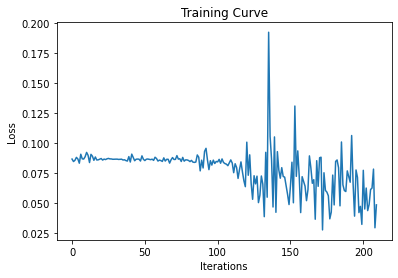

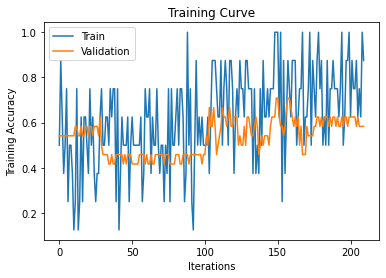

torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8,

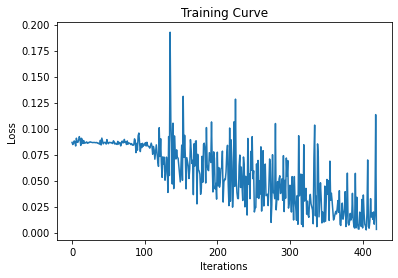

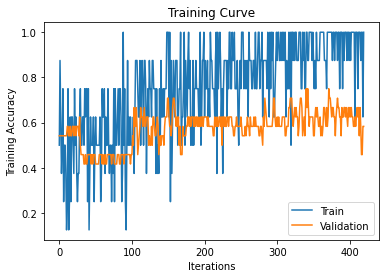

torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8,

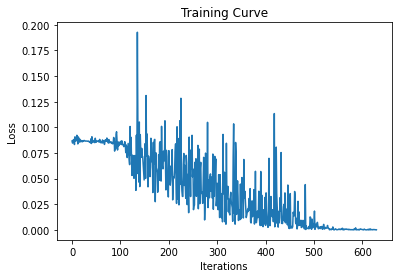

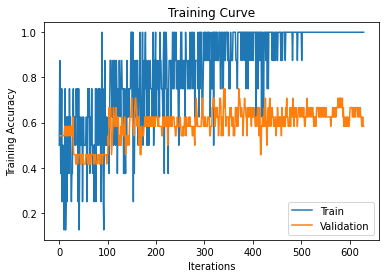

torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8,

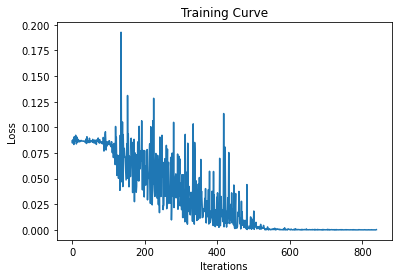

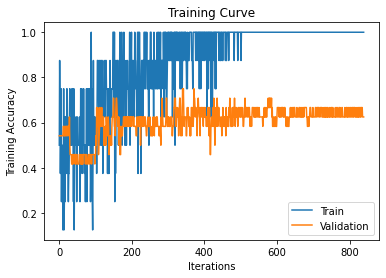

torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8, 3, 128, 192])
torch.Size([8,

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Indian_MelSpec_Img_exp4",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        #print("swiggity_swooty")
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs.float()) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        print(imgs.shape)
        total += imgs.shape[0]
    return correct / total

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1, shuffle=True, drop_last=True)
acc_net = CRNN2(config)

for imgs, labels in val_loader:
    #print(imgs)
    break

train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)